In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, metrics

In [2]:
def load_data(em_data = True, veh_data = True, air_data = True):
    args = []
    if em_data:
        EU_em_df = pd.read_excel('Data/EU_em.xlsx',engine='openpyxl')
        EU_em_annual_df = pd.read_csv('Data/EU_em_annual.csv',)
        UK_em_df = pd.read_excel('Data/UK_em.ods', nrows = 16)
        US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
        EU_em_df = EU_em_df.set_index('Month')
        EU_em_annual_df = EU_em_df.groupby(np.arange(len(EU_em_df))//(12)).sum()
        EU_em_annual_df.index = np.linspace(1973, 2021, EU_em_annual_df.shape[0], dtype=np.int32)
        UK_em_df = UK_em_df.transpose()
        UK_em_df.columns = UK_em_df.iloc[0, :]
        UK_em_df = UK_em_df.drop('Year')
        US_em_df = US_em_df.transpose()
        US_em_df.columns = US_em_df.iloc[0, :]
        US_em_df = US_em_df.drop('Gas/Vehicle')
        args += [EU_em_df, EU_em_annual_df, UK_em_df, US_em_df]
    if veh_data:
        EU_veh_df = pd.read_csv('Data/EU_veh.csv')
        UK_veh_df = pd.read_excel('Data/UK_veh.ods', nrows= 76)
        US_veh_df = pd.read_excel('Data/US_veh.xlsx')
        args += [EU_veh_df, UK_veh_df, US_veh_df]
    if air_data:
        # Secondary Data 
        # Air pollution
        # UK 1970-2019/2022
        UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
        UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
                
        # USA Since 1970-2020, plz Access through column id(numbers)
        USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
        USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
        USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
        
        USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
        USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
                
        # OCED DATA
        OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx')
    
    args += [UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df]
    
    return args



In [3]:
def train_test_split(X, y, split_point):
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test

def normalise(X):
    X_attrs = np.zeros((X.shape[-1], 2))
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    return X, X_attrs
        
def create_model(layers, input_shape):
    # Create and compile model
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model    


In [4]:
args = load_data()
EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df, UK_veh_df, US_veh_df, UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = args


C:\Apps\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [19]:
time_step = 5
data_memory = 5

X = EU_em_df.to_numpy()
X_norm, X_attrs = normalise(X)
X_norm, y_norm = np.split(X, [11], 1)
y_norm = np.roll(y_norm, - time_step)
nrows = X_norm.shape[0]
samples = X_norm.shape[1]
X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
split_point = int(X_norm.shape[0] *0.75)
x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)

In [23]:
input_shape = (x_train.shape[0], data_memory, samples)
model_layer = [layers.GRU(128, activation='tanh', recurrent_activation='sigmoid'),
                layers.Dense(1)]
model = create_model(model_layer, input_shape)
history = model.fit(x_train, y_train, validation_split = 0.1, epochs=5  , batch_size=1)
y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
mse = metrics.MeanSquaredError()
mse.update_state(y_norm, y_pred_norm)
test_loss = mse.result().numpy()
test_loss


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (439, 128)                54144     
                                                                 
 dense_2 (Dense)             (439, 1)                  129       
                                                                 
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
395/395 [==============================] - 3s 3ms/step - loss: 0.1255 - val_loss: 0.1809
Epoch 2/5
395/395 [==============================] - 1s 2ms/step - loss: 0.1021 - val_loss: 0.1969
Epoch 3/5
395/395 [==============================] - 1s 2ms/step - loss: 0.0884 - val_loss: 0.1684
Epoch 4/5
395/395 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.1584
Epoch 5/5
395/395 [==============================]

0.2384448

439

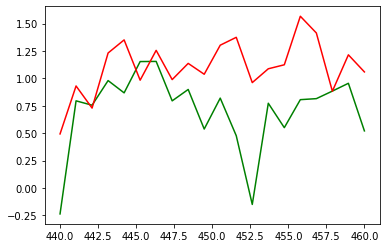

In [24]:
y = (y_norm/X_attrs[-1, 1]**0.5) + X_attrs[-1, 0]
y_pred = y_pred_norm /X_attrs[-1, 1]**0.5 + X_attrs[-1, 0]  
plot_range = [440]
plot_range += [plot_range[0] + 20]
t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')
split_point